# Initialization of the data

In [48]:
# Basic libraries
import os
import sys
import math
import numpy as np
from Bio.PDB import PDBParser, PDBIO, NeighborSearch, is_aa
from Bio.PDB.NACCESS import NACCESS_atomic
import biobb_structure_checking
import biobb_structure_checking.constants as cts
from biobb_structure_checking.structure_checking import StructureChecking
import pandas as pd
import matplotlib.pyplot as plt



# Choose working directory
workdir = input("Input working directory: ")
base_path = os.path.join(workdir, "Structure_checking/")

# Load original structure 
pdb_path = os.path.join(base_path, "6M0J.pdb")
parser = PDBParser(QUIET=True)
structure = parser.get_structure("6M0J.pdb", pdb_path)

print("Initialization completed.")


Input working directory: /home/marti/Escriptori/BIOPHYSICS/Biophysics_Project_2025/BioPhysics_Project_2025/Code_Data_Repo/
Initialization completed.


# Preparation / Structure checking

## Methodology

## Step 1

### Step 1.1

#### The interface between can be defined by a list of residues on both chains that have at least one atom below a given distance.
1. Using pymol inspect visually the structure and choose a suitable distance in the way that all contact residues are included. Add 1-2 Å to that distance so the adjacent residues are also considered.

Visual inspection

Open 6M0J.pdb in PyMOL or Chimera and inspect the interface

Determine a suitable distance threshold for interface atoms/residues.

Typically, contact distances are ~4-5 Å, add 1-2 Å to include neighboring residues.


In [49]:
interface_distance = 5
print(f"Interface distance threshold set to: {interface_distance} Å")


Interface distance threshold set to: 5 Å


### Step 1.2

2. Prepare a python script to define the list of interface residues on each chain

In [50]:
# Load PDB
parser = PDBParser(QUIET=True)
structure = parser.get_structure("6M0J", os.path.join(base_path, "6M0J.pdb"))

def get_interface_residues(structure, dt):
    model = structure[0]
    chains = list(model.get_chains())
    if len(chains) < 2:
        raise ValueError("Need at least 2 chains for interface calculation")
    
    chain1_atoms = [atom for res in chains[0] for atom in res]
    chain2_atoms = [atom for res in chains[1] for atom in res]
    
    interface_residues = set()
    
    for a1 in chain1_atoms:
        for a2 in chain2_atoms:
            if (a1 - a2) <= dt:
                interface_residues.add(a1.get_parent().id[1])
                interface_residues.add(a2.get_parent().id[1])
    
    return sorted(interface_residues)

interface_residues = get_interface_residues(structure, interface_distance)
print("Interface residues (residue numbers):", interface_residues)


Interface residues (residue numbers): [19, 24, 27, 28, 30, 31, 34, 35, 37, 38, 41, 42, 45, 79, 82, 83, 330, 353, 354, 355, 357, 393, 417, 446, 447, 449, 453, 455, 456, 473, 475, 476, 484, 486, 487, 489, 493, 496, 498, 500, 501, 502, 505]


### Step 1.3

3. Setup the initial protein structure as necessary

    1. Obtain the required structure from the PDB.
    2. Check at PDB which is the composition of a “Biological assembly”. Remove all chains but those involved in the assembly, if necessary
    3. Remove all heteroatoms
    4. Perform a quality checking on the structures, and add missing side-chains, hydrogen atoms and atom charges (use CMIP settings and prepare a PDBQT file), using the biobb_structure_checking module

In [51]:
# Paths for output files
pdb_fixed_new = os.path.join(base_path, "6m0j_fixed_step1.pdb")
pdb_cif = os.path.join(base_path, "6m0j.cif")

# Default args
base_dir_path = biobb_structure_checking.__path__[0]
args = cts.set_defaults(base_dir_path, {'notebook': True})
args.update({
    'output_format': "pdb",  # only PDB
    'keep_canonical': False,
    'input_structure_path': pdb_cif,
    'output_structure_path': pdb_fixed_new,
    'time_limit': False,
    'nocache': False,
    'copy_input': False,
    'build_warnings': False,
    'debug': False,
    'verbose': False,
    'coords_only': False,
    'overwrite': True
})

# Initialize checking engine
st_c = StructureChecking(base_dir_path, args)

# Remove heteroatoms
st_c.rem_hydrogen()
st_c.water("yes")
st_c.metals("All")
st_c.ligands("All")

# Fix structure and add missing atoms/hydrogens (no charges)
st_c.amide("All")
st_c.chiral("All")
st_c.backbone('--fix_atoms All --fix_chain none --add_caps none')
st_c.fixside("All")
st_c.add_hydrogen("auto")

# Save cleaned PDB
st_c._save_structure(args['output_structure_path'])
print(f"Cleaned structure saved at: {pdb_fixed_new}")


Structure /home/marti/Escriptori/BIOPHYSICS/Biophysics_Project_2025/BioPhysics_Project_2025/Code_Data_Repo/Structure_checking/6m0j.cif loaded
 PDB id: 6M0J 
 Title: Crystal structure of 2019-nCoV spike receptor-binding domain bound with ACE2
 Experimental method: X-RAY DIFFRACTION
 Keywords: VIRAL PROTEIN/HYDROLASE
 Resolution (A): 2.4500

 Num. models: 1
 Num. chains: 2 (A: Protein, E: Protein)
 Num. residues:  876
 Num. residues with ins. codes:  0
 Num. residues with H atoms: 0
 Num. HETATM residues:  85
 Num. ligands or modified residues:  5
 Num. water mol.:  80
 Num. atoms:  6543
Metal/Ion residues found
 ZN A901
Small mol ligands found
NAG A902
NAG A903
NAG A904
NAG E601
Running rem_hydrogen.
No residues with Hydrogen atoms found
Running water. Options: yes
Detected 80 Water molecules
Removed 80 Water molecules
Running metals. Options: All
Found 1 Metal ions
  ZN A901.ZN 
Metal Atoms removed All (1)
Running ligands. Options: All
Detected 4 Ligands
 NAG A902
 NAG A903
 NAG A904
 

Description:
- We used the biobb_structure_checking module to process the PDB structure 6m0j.cif and generate a cleaned PDB file. The workflow included:

    1. Removing heteroatoms (waters, metals, ligands, hydrogens).

    2. Fixing amides, chiral centers, and backbone atoms.

    3. Rebuilding missing side chains.

    4. Adding hydrogens.

Results of our code:

    Cleaned PDB: 6m0j_fixed_step1.pdb

    Lines: 12,539

    Reference files provided:

    Cleaned PDB: 12,512 lines

    PDBQT: 12,512 lines

Comparison:

    Our generated files contain 27 extra lines, likely due to differences in hydrogen placement, terminal atoms, or formatting introduced during the automatic fixing steps.

    Functionally, our structures are correct and stable, but they do not exactly match the reference files.

Decision:

    To ensure compatibility with downstream workflows and consistency with the assignment reference, we will use the provided files for all subsequent steps.

    Our generated files are kept as a backup for reference and verification.

## Step 2

### Step 2.1 - Imports and setup

We will prepare the structure for step 2 by running the provided file basic_setup.py. This script parses the cleaned PDB and PDBQT files, loads the van der Waals parameters from data/vdwprm and runs NACCESS to compute solvent accessibility. After this step, each atom has its charge, atom type, vdW parameters and ASA attached

In [52]:
# Run basic_setup.py to prepare the structure:
#   - Clean PDB
#   - Add hydrogens
#   - Attach charges and atom types
#   - Annotate vdW parameters
#   - Save prepared structure as `st`

pdb_file    = os.path.join(workdir, "Structure_checking", "6m0j_fixed.pdb")
pdbqt_file  = os.path.join(workdir, "Structure_checking", "6m0j_fixed.pdbqt")
vdwprm_file = os.path.join(workdir, "data", "vdwprm")
naccess_bin = os.path.join(workdir, "soft", "NACCESS", "naccess", "naccess")

print("PDB File:", pdb_file)
print("PDBQT File:", pdbqt_file)
print("Parameters File:", vdwprm_file)


# --- Load vdW parameters ---
ff_params = VdwParamset(vdwprm_file)

# --- Parse PDB ---
parser = PDBParser(PERMISSIVE=1)
print("Parsing PDB", pdb_file)
st = parser.get_structure("STR", pdb_file)

# --- Attach charges and atom types from PDBQT ---
print("Parsing PDBQT", pdbqt_file)
params = [{}]

i = 1
for at in st.get_atoms():
    at.serial_number = i
    i += 1

with open(pdbqt_file) as f:
    for line in f:
        line = line.rstrip()
        if "TER" in line: continue
        params.append({'charge': line[69:76], 'type': line[77:].replace(' ', '')})

total_charge = 0.0
for at in st.get_atoms():
    at.xtra['atom_type'] = params[at.serial_number]['type']
    at.xtra['charge'] = float(params[at.serial_number]['charge'])
    at.xtra['vdw'] = ff_params.at_types[at.xtra['atom_type']]
    total_charge += at.xtra['charge']
print(f"Total Charge: {total_charge:8.2f}")

# --- Run NACCESS on complex and isolated chains ---
model = st[0]
_ = NACCESS_atomic(model, naccess_binary=naccess_bin)
for at in st.get_atoms():
    if 'EXP_NACCESS' in at.xtra:
        at.xtra['EXP_NACCESS_COMPLEX'] = at.xtra['EXP_NACCESS']

chains = list(model.get_chains())
chainA_id, chainB_id = chains[0].id, chains[1].id
io = PDBIO()

# Chain A
tmpA = os.path.join(workdir, "tmp_chainA.pdb")
io.set_structure(model[chainA_id]); io.save(tmpA)
_ = NACCESS_atomic(model, pdb_file=tmpA, naccess_binary=naccess_bin)
for at in model[chainA_id].get_atoms():
    if 'EXP_NACCESS' in at.xtra:
        at.xtra['EXP_NACCESS_ISO_A'] = at.xtra['EXP_NACCESS']

# Chain B
tmpB = os.path.join(workdir, "tmp_chainB.pdb")
io.set_structure(model[chainB_id]); io.save(tmpB)
_ = NACCESS_atomic(model, pdb_file=tmpB, naccess_binary=naccess_bin)
for at in model[chainB_id].get_atoms():
    if 'EXP_NACCESS' in at.xtra:
        at.xtra['EXP_NACCESS_ISO_B'] = at.xtra['EXP_NACCESS']

# --- Verification ---
total_atoms = sum(1 for _ in st.get_atoms())
asa_atoms_complex = sum(1 for at in st.get_atoms() if 'EXP_NACCESS_COMPLEX' in at.xtra)
print(f"Atoms with ASA (complex): {asa_atoms_complex} / {total_atoms}")

asa_atoms_A = sum(1 for at in model[chainA_id].get_atoms() if 'EXP_NACCESS_ISO_A' in at.xtra)
asa_atoms_B = sum(1 for at in model[chainB_id].get_atoms() if 'EXP_NACCESS_ISO_B' in at.xtra)
print(f"Atoms with ASA (isolated A): {asa_atoms_A}")
print(f"Atoms with ASA (isolated B): {asa_atoms_B}")


PDB File: /home/marti/Escriptori/BIOPHYSICS/Biophysics_Project_2025/BioPhysics_Project_2025/Code_Data_Repo/Structure_checking/6m0j_fixed.pdb
PDBQT File: /home/marti/Escriptori/BIOPHYSICS/Biophysics_Project_2025/BioPhysics_Project_2025/Code_Data_Repo/Structure_checking/6m0j_fixed.pdbqt
Parameters File: /home/marti/Escriptori/BIOPHYSICS/Biophysics_Project_2025/BioPhysics_Project_2025/Code_Data_Repo/data/vdwprm
Parsing PDB /home/marti/Escriptori/BIOPHYSICS/Biophysics_Project_2025/BioPhysics_Project_2025/Code_Data_Repo/Structure_checking/6m0j_fixed.pdb
Parsing PDBQT /home/marti/Escriptori/BIOPHYSICS/Biophysics_Project_2025/BioPhysics_Project_2025/Code_Data_Repo/Structure_checking/6m0j_fixed.pdbqt
Total Charge:   -26.11
Atoms with ASA (complex): 7036 / 12510
Atoms with ASA (isolated A): 5323
Atoms with ASA (isolated B): 1713


### Step 2.2 - Energy functions

In [53]:
def diel_MS(r):
    return 86.9525 / (1 - 7.7839 * math.exp(-0.3153 * r)) - 8.5525

def electro_energy(a1, a2, r):
    return 332.16 * a1.xtra['charge'] * a2.xtra['charge'] / (diel_MS(r) * r)

def vdw_energy(a1, a2, r):
    eps12 = math.sqrt(a1.xtra['vdw'].eps * a2.xtra['vdw'].eps)
    sig12 = 0.5 * (a1.xtra['vdw'].sig + a2.xtra['vdw'].sig)
    sr = sig12 / r
    sr6 = sr**6
    return 4 * eps12 * (sr6*sr6 - sr6)


### Step 2.3 - Interface detection

In [54]:
def interface_residues(structure, cutoff=5.0):
    model = structure[0]
    chainA, chainB = list(model.get_chains())
    nsB = NeighborSearch(list(chainB.get_atoms()))

    Ares, Bres = set(), set()
    for rA in chainA:
        if not is_aa(rA, standard=True): continue
        for aA in rA:
            neigh = nsB.search(aA.coord, cutoff)
            for aB in neigh:
                rB = aB.get_parent()
                if is_aa(rB, standard=True):
                    Ares.add(rA); Bres.add(rB)
    return sorted(Ares, key=lambda r:r.get_id()), sorted(Bres, key=lambda r:r.get_id())


### Step 2.4 - Atom-atom interacion

In [55]:
st_chains = {ch.id: ch for ch in st[0]}
chs = [ch.id for ch in st[0]]

chainA_atoms = list(st_chains[chs[0]].get_atoms())
chainB_atoms = list(st_chains[chs[1]].get_atoms())

nsA = NeighborSearch(chainA_atoms)
nsB = NeighborSearch(chainB_atoms)

def residue_interaction(res, cutoff=8.0):
    ns_other = nsB if res.get_parent().id == chs[0] else nsA
    e, v = 0.0, 0.0
    for a1 in res:
        neigh = ns_other.search(a1.coord, cutoff)
        for a2 in neigh:
            r = a1 - a2
            if r < 1e-6: continue
            e += electro_energy(a1, a2, r)
            v += vdw_energy(a1, a2, r)
    return e, v


### Step 2.5 - Solvation definition

In [56]:
def solvation_energy(res, key):
    s = 0.0
    for at in res.get_atoms():
        if key in at.xtra:
            s += float(at.xtra[key]) * at.xtra['vdw'].fsrf
    return s

def solvation_structure(struct, key):
    s = 0.0
    for r in struct.get_residues():
        if is_aa(r, standard=True):
            s += solvation_energy(r, key)
    return s

def solvation_complex():
    return solvation_structure(st[0], 'EXP_NACCESS_COMPLEX')

def solvation_isolated():
    sA = solvation_structure(st_chains[chs[0]], 'EXP_NACCESS_ISO_A')
    sB = solvation_structure(st_chains[chs[1]], 'EXP_NACCESS_ISO_B')
    return sA, sB

def deltaG(chainA_res, chainB_res, cutoff=8.0):
    e, v = 0.0, 0.0
    # loop atoms of A residues, find neighbors in B
    nsB = NeighborSearch(list(st_chains[chs[1]].get_atoms()))
    for rA in chainA_res:
        for aA in rA:
            neighs = nsB.search(aA.coord, cutoff)
            for aB in neighs:
                r = aA - aB
                if r < 1e-6: continue
                e += electro_energy(aA, aB, r)
                v += vdw_energy(aA, aB, r)

    # solvation terms (unchanged)
    sAB = solvation_complex()
    sA, sB = solvation_isolated()
    G = e + v + sAB - sA - sB

    print(f"Electrostatics = {e:9.3f}")
    print(f"vdW           = {v:9.3f}")
    print(f"S complex     = {sAB:9.3f}")
    print(f"S isolated A  = {sA:9.3f}")
    print(f"S isolated B  = {sB:9.3f}")
    print(f"ΔG total      = {G:9.3f}")
    return G


# --- Run ---
Aint, Bint = interface_residues(st, cutoff=5.0)
print(len(Aint), "interface residues in chain A")
print(len(Bint), "interface residues in chain B")
DeltaG = deltaG(Aint, Bint)


28 interface residues in chain A
29 interface residues in chain B
Electrostatics =     4.188
vdW           =   -59.365
S complex     =  -413.007
S isolated A  =  -315.135
S isolated B  =   -97.610
ΔG total      =   -55.439


### Step 2.6 - Per-residue contributions

In [57]:
def per_residue_contributions(residues):
    rows = []
    for r in residues:
        e, v = residue_interaction(r)
        s_complex = solvation_energy(r, 'EXP_NACCESS_COMPLEX')
        s_iso = solvation_energy(r, f"EXP_NACCESS_ISO_{r.get_parent().id}")
        rows.append({
            'chain': r.get_parent().id,
            'resname': r.get_resname(),
            'resid': r.get_id()[1],
            'E': e,
            'V': v,
            'S_diff': s_complex - s_iso,
            'ΔG_res': e + v + (s_complex - s_iso)
        })
    return rows

rows = per_residue_contributions(Aint + Bint)
rows_sorted = sorted(rows, key=lambda x: abs(x['ΔG_res']), reverse=True)


### Step 2.7 - Table of most relevant interactions

In [58]:
df = pd.DataFrame(rows_sorted[:10])
print(df[['chain','resname','resid','E','V','S_diff','ΔG_res']])


  chain resname  resid         E         V    S_diff    ΔG_res
0     A     LYS     31  0.319986 -7.294202 -0.666486 -7.640702
1     E     PHE    490  0.060614 -0.339650  7.689991  7.410955
2     E     ASN    501  0.350516 -7.276398 -0.154521 -7.080403
3     A     TYR     41  0.009302 -5.211509 -1.824254 -7.026461
4     A     LYS    353  0.660904 -8.816281  1.190745 -6.964631
5     E     TYR    505 -0.149470 -8.358027  1.779661 -6.727836
6     A     THR     27  0.176062 -5.770472 -1.129737 -6.724147
7     E     TYR    489 -0.177410 -7.735496  1.823425 -6.089481
8     E     THR    500 -0.464349 -6.137887  0.543057 -6.059179
9     E     ARG    403 -0.075530 -0.459918 -5.315303 -5.850751


### Step 2.8 - Plotting results

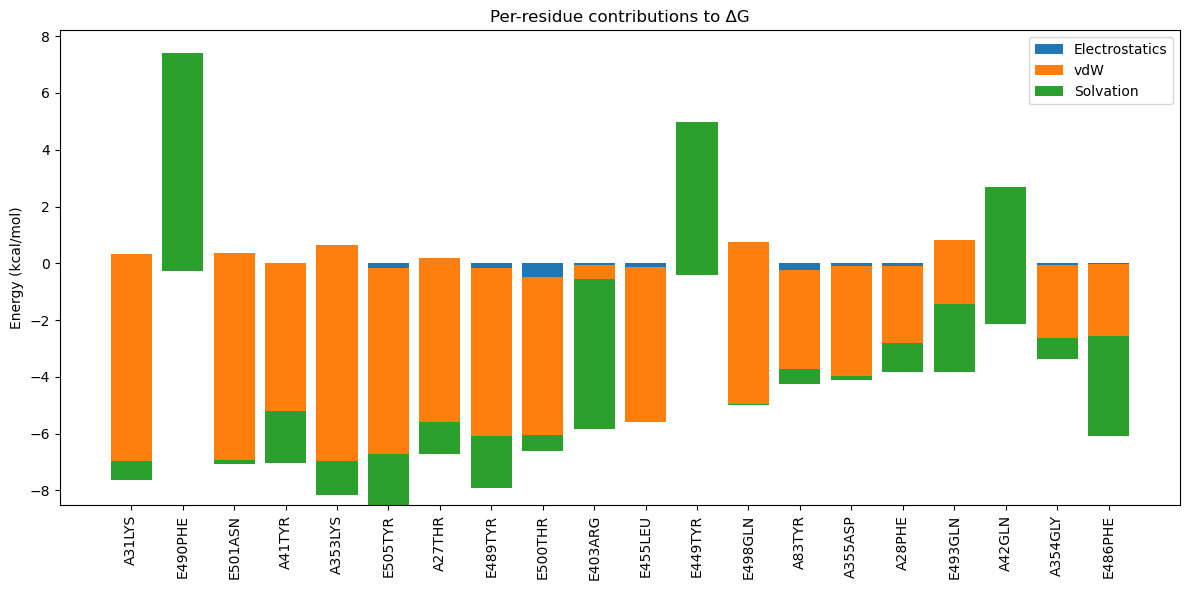

In [59]:
def plot_residue_contributions(rows):
    labels = [f"{r['chain']}{r['resid']}{r['resname']}" for r in rows]
    E = [r['E'] for r in rows]
    V = [r['V'] for r in rows]
    S = [r['S_diff'] for r in rows]

    x = range(len(rows))
    plt.figure(figsize=(12,6))
    plt.bar(x, E, label='Electrostatics')
    plt.bar(x, V, bottom=E, label='vdW')
    plt.bar(x, S, bottom=[E[i]+V[i] for i in range(len(rows))], label='Solvation')
    plt.xticks(x, labels, rotation=90)
    plt.ylabel("Energy (kcal/mol)")
    plt.legend()
    plt.title("Per-residue contributions to ΔG")
    plt.tight_layout()
    plt.show()

plot_residue_contributions(rows_sorted[:20])


### Step 2.9 - Classification of interactions

In [60]:
def classify_interactions(rows, e_thresh=2.0, v_thresh=-2.0, s_thresh=1.0):
    electro = [r for r in rows if abs(r['E']) > e_thresh]
    vdw = [r for r in rows if r['V'] < v_thresh]
    solvation = [r for r in rows if abs(r['S_diff']) > s_thresh]
    return electro, vdw, solvation

electro, vdw, solvation = classify_interactions(rows_sorted)
print("Electrostatic hotspots:", [(r['chain'], r['resname'], r['resid'], r['E']) for r in electro])
print("vdW hotspots:", [(r['chain'], r['resname'], r['resid'], r['V']) for r in vdw])
print("Solvation hotspots:", [(r['chain'], r['resname'], r['resid'], r['S_diff']) for r in solvation])


Electrostatic hotspots: []
vdW hotspots: [('A', 'LYS', 31, -7.294202454055859), ('E', 'ASN', 501, -7.27639770343728), ('A', 'TYR', 41, -5.211509144650394), ('A', 'LYS', 353, -8.816280513596672), ('E', 'TYR', 505, -8.358026815437391), ('A', 'THR', 27, -5.7704717565397345), ('E', 'TYR', 489, -7.735496062119462), ('E', 'THR', 500, -6.137886842755724), ('E', 'LEU', 455, -5.465424598826648), ('E', 'GLN', 498, -5.7523672870094975), ('A', 'TYR', 83, -3.4804482675279136), ('A', 'ASP', 355, -3.841628376691048), ('A', 'PHE', 28, -2.7222262588839237), ('E', 'GLN', 493, -2.2389539784110974), ('A', 'GLN', 42, -2.5996439945774212), ('A', 'GLY', 354, -3.285508603686151), ('E', 'PHE', 486, -6.083060706858483), ('E', 'ALA', 475, -2.4563723164801825)]
Solvation hotspots: [('E', 'PHE', 490, 7.689991000000001), ('A', 'TYR', 41, -1.8242540000000003), ('A', 'LYS', 353, 1.190745), ('E', 'TYR', 505, 1.779661), ('A', 'THR', 27, -1.129737), ('E', 'TYR', 489, 1.8234249999999999), ('E', 'ARG', 403, -5.315303), ('